## 1. Подключение необходимых библиотек и данных
По мере необходиомсти, в самом начале будем подключать все библиотеки и прописывать глобальные пути и переменные.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
from scipy import stats
from datetime import datetime 
from sklearn.model_selection import train_test_split, cross_val_score,  KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
matplotlib.rcParams.update({'font.size': 14})
TRAIN_PATH = './data/train.csv'
TEST_PATH = './data/test.csv'
SUBMIT_PATH = './data/submission_example.csv'

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 6)) + "\n" +
            "Train MAE:\t" + str(round(mae(train_true_values, train_pred_values), 6)) + "\n" +
            "Train MSE:\t" + str(round(mse(train_true_values, train_pred_values), 6)))

    print("\n" +
            "Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 6)) + "\n" +
            "Test MAE:\t" + str(round(mae(test_true_values, test_pred_values), 6)) + "\n" +
            "Test MSE:\t" + str(round(mse(test_true_values, test_pred_values), 6)))
    
    plt.figure(figsize=(15,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()
    
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique_labels, labels_counts)

    plt.xlabel('Clusters')
    plt.xticks(unique_labels)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def show_feature_importances(feature_names, feature_importances, get_top=None):
    """Важность признаков"""
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## 2. Загрузка данных в Data Frame
#### Описание файлов
- train.csv - тренировочные данные
- test.csv - тестовые данные
- sampleSubmission.csv - образец файла для отправки в правильном формате

In [3]:
# Импортируем данные train.csv в pandas Dataframe
df_train = pd.read_csv(TRAIN_PATH, sep=',')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [4]:
df_train = df_train.set_index('Id')
df_train.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
Id,,,,,,,,,,,
0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [5]:
# Посмотрим основные статистики
df_train.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


## Обработка данных

In [6]:
df_train = pd.read_csv(TRAIN_PATH, sep=',')
test_df = pd.read_csv(TEST_PATH, sep=',')
sumbit_df = pd.read_csv(SUBMIT_PATH, sep=',')
df_train = df_train.set_index('Id')
test_df = test_df.set_index('Id')

In [7]:
y = df_train['mean_exam_points']
X = df_train.drop(columns=['mean_exam_points'])

In [8]:
# Для начала отмасштабируем выборку
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
test = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

In [9]:
X = reduce_mem_usage(X)
test = reduce_mem_usage(test)

Memory usage of dataframe is 0.76 MB
Memory usage after optimization is: 0.38 MB
Decreased by 50.0%
Memory usage of dataframe is 0.76 MB
Memory usage after optimization is: 0.38 MB
Decreased by 50.0%


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train R2:	0.811599
Train MAE:	4.472928
Train MSE:	34.72702

Test R2:	0.781904
Test MAE:	4.751728
Test MSE:	39.240412


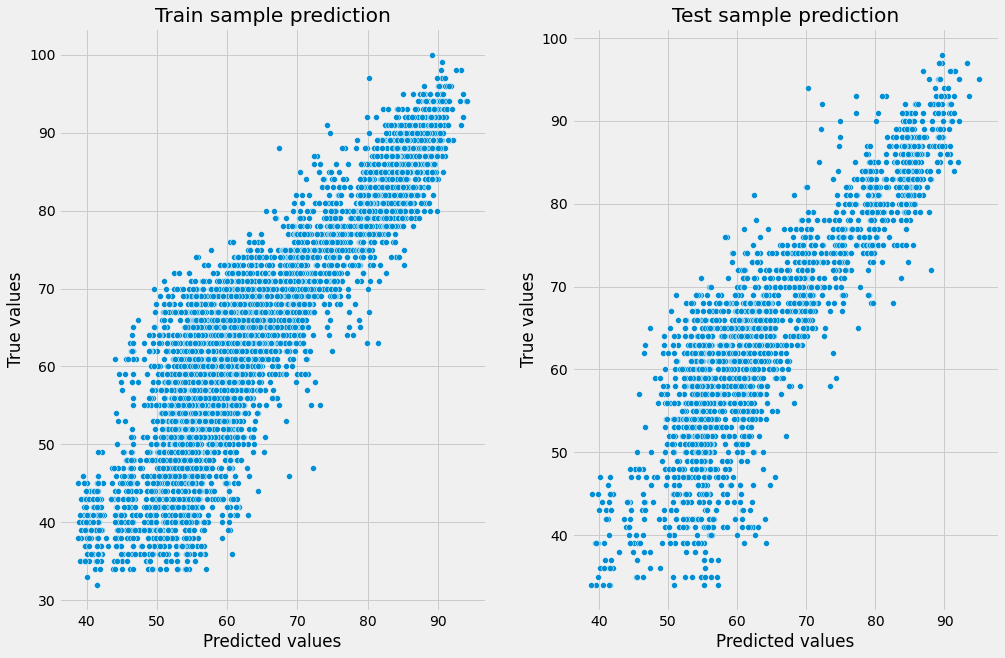

In [11]:
import catboost as catb
frozen_params = {'silent':True,
                 'random_state':42,
                 'eval_metric':'RMSE',
                 'early_stopping_rounds':100
}

model = catb.CatBoostRegressor(**frozen_params, iterations=300, min_data_in_leaf = 3)
model.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

y_train_preds = model.predict(X_train)
y_valid_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [12]:
from sklearn.model_selection import StratifiedKFold

params = {'reg_lambda': np.linspace(0.01, 0.2, 50)}

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

model = catb.CatBoostRegressor(**frozen_params,
                                iterations=300,
                                min_data_in_leaf = 3
                                )

grid_search = model.randomized_search(params, 
                        X_train, y_train, n_iter=20, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 6.494222124
bestIteration = 297

0:	loss: 6.4942221	best: 6.4942221 (0)	total: 1.71s	remaining: 32.4s

bestTest = 6.486670334
bestIteration = 299

1:	loss: 6.4866703	best: 6.4866703 (1)	total: 3.72s	remaining: 33.5s

bestTest = 6.488898012
bestIteration = 297

2:	loss: 6.4888980	best: 6.4866703 (1)	total: 5.73s	remaining: 32.5s

bestTest = 6.482787675
bestIteration = 299

3:	loss: 6.4827877	best: 6.4827877 (3)	total: 7.47s	remaining: 29.9s

bestTest = 6.49229273
bestIteration = 299

4:	loss: 6.4922927	best: 6.4827877 (3)	total: 9.39s	remaining: 28.2s

bestTest = 6.490264325
bestIteration = 299

5:	loss: 6.4902643	best: 6.4827877 (3)	total: 11.1s	remaining: 25.8s

bestTest = 6.485302606
bestIteration = 299

6:	loss: 6.4853026	best: 6.4827877 (3)	total: 12.5s	remaining: 23.2s

bestTest = 6.494076564
bestIteration = 299

7:	loss: 6.4940766	best: 6.4827877 (3)	total: 13.9s	remaining: 20.9s

bestTest = 6.491084291
bestIteration = 299

8:	loss: 6.4910843	best: 6.4827877 (3)	total

In [15]:
reg_lambda_ = grid_search['params']['l2_leaf_reg']
reg_lambda_

0.060408163265306125

### Важность признаков<a class="anchor" id="feature_importances"></a>

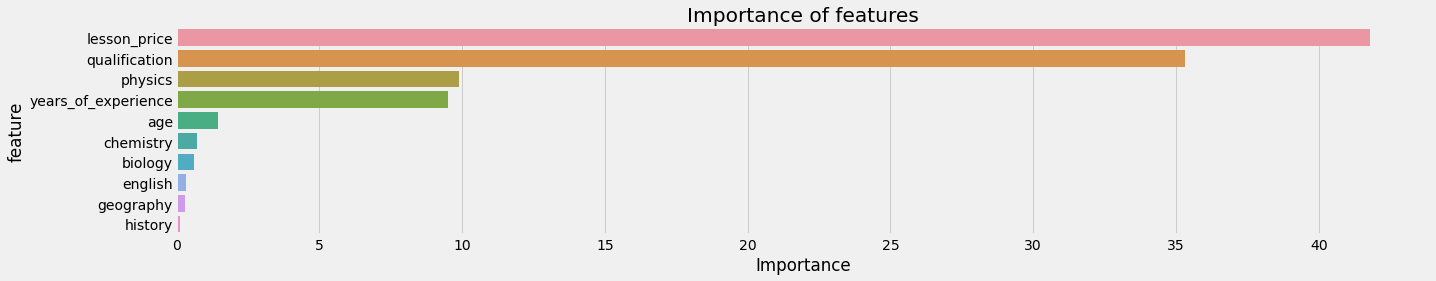

In [13]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_)

### Построение лучшей модели

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train R2:	0.80869
Train MAE:	4.512926
Train MSE:	35.263149

Test R2:	0.781238
Test MAE:	4.760838
Test MSE:	39.360177


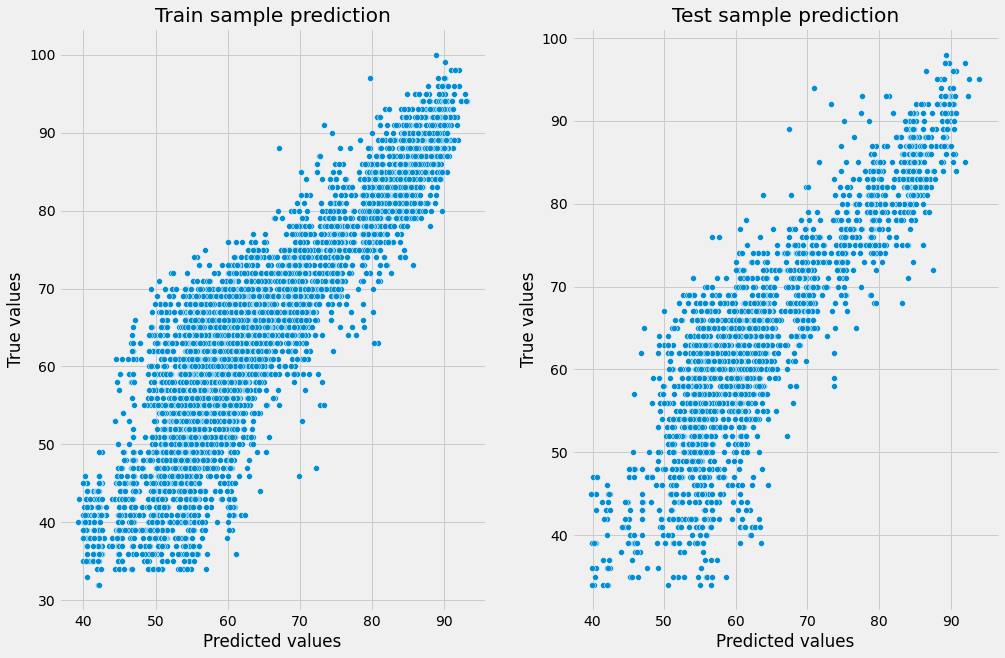

In [16]:
final_model = catb.CatBoostRegressor(**frozen_params,
                                      iterations=490,
                                      min_data_in_leaf = 3,
                                      reg_lambda=reg_lambda_
                                      )

final_model.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

y_train_preds = final_model.predict(X_train)
y_valid_preds = final_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

### Прогнозирование на тестовом датасете

In [17]:
y_test_preds = final_model.predict(test)
sumbit_df['mean_exam_points'] = y_test_preds
sumbit_df.head()

,Id,mean_exam_points
0,10000,55.612992
1,10001,63.392221
2,10002,49.331078
3,10003,90.966772
4,10004,89.183802


In [18]:
sumbit_df.to_csv('sample_submission.csv', index=False)